<a href="https://colab.research.google.com/github/gustavox0/Tecnicas-Avanzdas-ML/blob/main/M7_AI1_SalazarGustavo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Contexto**

En esta práctica realizaremos clasificación de imágenes con Support Vector Machine. Para ello, utilizaremos dos datasets: CIFAR-10 y EUROSAT-RGB.

**CIFAR-10**

  - Es un subconjunto del “80 million tiny images” creado por Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.
  - Consta de 50.000 imágenes de entrenamiento y 10.000 de prueba. El tamaño de la imagen es de 32 x 32 píxeles en RGB (3 canales). Cada imagen está etiquetada de 0 a 9 en función de la clase: airplane, automobile, bird, cat, deer, dog, frog, horse, ship y truck.

Se utiliza como banco de pruebas para clasificar imágenes con algoritmos de Machine Learning.

**EUROSAT RGB**

  - Este dataset fue uno de los primeros esfuerzos de creación de recursos libres y abiertos para promover la observación de la tierra desde el espacio.
  - Es un dataset compuesto por imágenes del satélite Sentinel 2, que contiene 27000 imágenes en RGB de 64x64 en RGB (3 canales), anotadas en 10 clases: Industrial buildings, residential buildings, annual crop, permanent crop, river, sea & lake, herbaceous vegetation, highway, pasture, y forest.

El objetivo es comparar el resultado (accuracy) en función del dataset y el tipo de kernel SVM.

Teniendo en cuenta la información anterior, te pedimos realizar las tareas siguientes:

# Datasets

In [4]:
#paquetes generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#para carga de datasets
import tensorflow as tf
import tensorflow_datasets as tfds
#para el conteo de imágenes EUROSAT
from collections import defaultdict
#para modelos svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#para medidas de accuracy y matrices de confusion
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#para busqueda gridsearch
from sklearn.model_selection import GridSearchCV
from time import time
import datetime
#para tablas de comparacion
from IPython.display import display, HTML

## 1.Carga de datasets

Cargar ambos datasets desde tensorflow. Más información en https://www.tensorflow.org/datasets/catalog/cifar10 y  https://www.tensorflow.org/datasets/catalog/eurosat (versión rgb)

### CIFAR-10

In [5]:
# Descargar CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Tamaño del set de entrenamiento:", x_train.shape)
print("Tamaño del set de prueba:", x_test.shape)
print("Tamaño del vector de etiquetas:", y_train.shape)
print("Tamaño del vector de etiquetas:", y_test.shape)

Tamaño del set de entrenamiento: (50000, 32, 32, 3)
Tamaño del set de prueba: (10000, 32, 32, 3)
Tamaño del vector de etiquetas: (50000, 1)
Tamaño del vector de etiquetas: (10000, 1)


  - Visualizar algunas imágenes del dataset

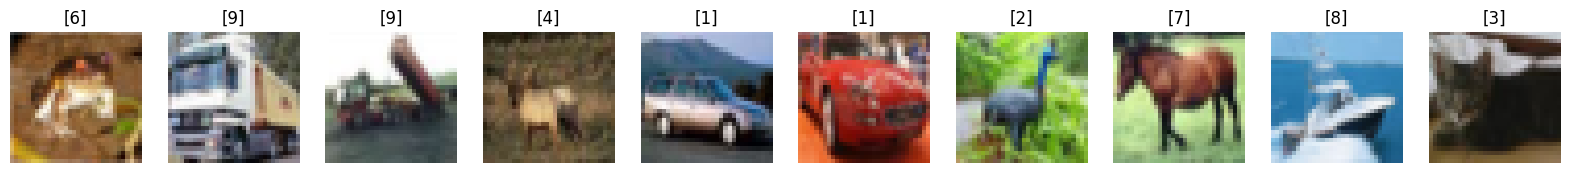

In [6]:
# Mostrar 10 primeras imágenes de entrenamiento
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].set_title(y_train[i])
    axes[i].axis('off') # Hide axes ticks
plt.show()


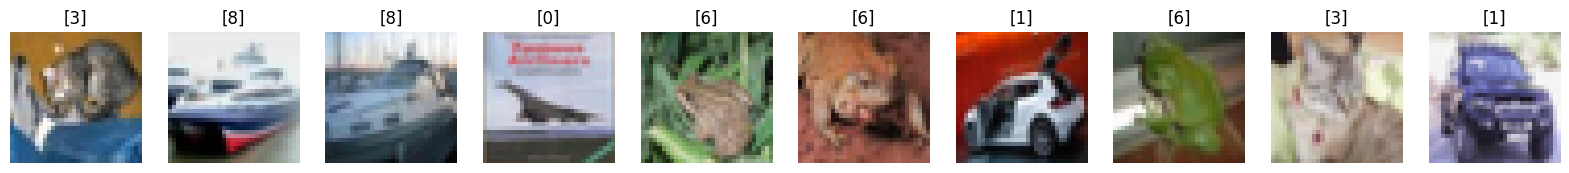

In [7]:
# Mostrar 10 primeras imágenes de prueba
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(x_test[i], cmap='gray')
    axes[i].set_title(y_test[i])
    axes[i].axis('off') # Hide axes ticks
plt.show()

In [8]:
#Información general de los datasets
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Nombe de las clases:", cifar10_class_names)
print("Nº de clases:", len(cifar10_class_names))

print("Nº instancias (train set):", x_train.shape[0])
print("Nº instancias (test set):", x_test.shape[0])

# Nº instancias por clase
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
print("Nº instancias por clase (train set):")
for i in range(len(unique_classes_train)):
    print(f"\tClase '{cifar10_class_names[unique_classes_train[i]]}': {counts_train[i]}")

unique_classes_test, counts_test = np.unique(y_test, return_counts=True)
print("Nº instancias por clase (test set):")
for i in range(len(unique_classes_test)):
    print(f"\tClase '{cifar10_class_names[unique_classes_test[i]]}': {counts_test[i]}")


Nombe de las clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Nº de clases: 10
Nº instancias (train set): 50000
Nº instancias (test set): 10000
Nº instancias por clase (train set):
	Clase 'airplane': 5000
	Clase 'automobile': 5000
	Clase 'bird': 5000
	Clase 'cat': 5000
	Clase 'deer': 5000
	Clase 'dog': 5000
	Clase 'frog': 5000
	Clase 'horse': 5000
	Clase 'ship': 5000
	Clase 'truck': 5000
Nº instancias por clase (test set):
	Clase 'airplane': 1000
	Clase 'automobile': 1000
	Clase 'bird': 1000
	Clase 'cat': 1000
	Clase 'deer': 1000
	Clase 'dog': 1000
	Clase 'frog': 1000
	Clase 'horse': 1000
	Clase 'ship': 1000
	Clase 'truck': 1000


### EUROSAT RGB

In [9]:
ds = tfds.load('eurosat/rgb', split='train', shuffle_files=True)

# Nombres de clases
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

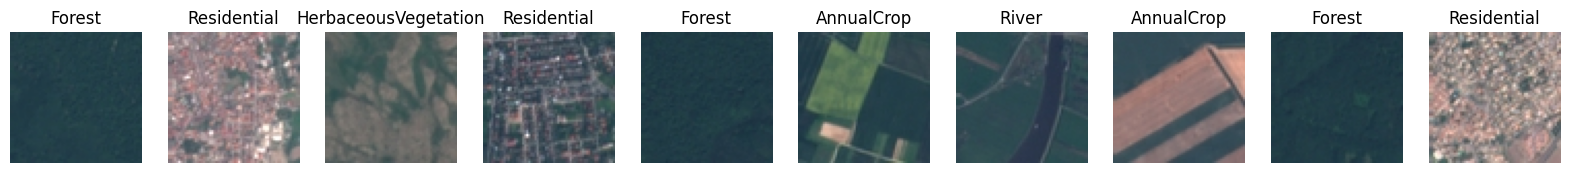

In [10]:
# Mostrar 10 primeras imágenes del dataset EUROSAT RGB
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, example in enumerate(ds.take(10)):
    image = example['image'].numpy()
    label = example['label'].numpy()
    axes[i].imshow(image)
    axes[i].set_title(class_names[label])
    axes[i].axis('off') # Hide axes ticks
plt.show()

In [11]:
# Contar imágenes por clase
class_counts = defaultdict(int)
for example in ds:
    label = example['label'].numpy()
    class_counts[class_names[label]] += 1

print("Distribución de clases:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} imágenes")

Distribución de clases:
Forest: 3000 imágenes
Residential: 3000 imágenes
HerbaceousVegetation: 3000 imágenes
AnnualCrop: 3000 imágenes
River: 2500 imágenes
Industrial: 2500 imágenes
Pasture: 2000 imágenes
SeaLake: 3000 imágenes
PermanentCrop: 2500 imágenes
Highway: 2500 imágenes


## 2.Preprocesado

Convertir las imágenes en vectores unidimensionales. Si fuese necesario, por limitaciones de recursos computacionales (tiempo y memoria) de Colab, se permite también reducir la dimensionalidad mediante técnicas como PCA después de convertir las imágenes en vectores.

In [12]:
#vectorizacion de CIFAR-10
x_train_uni = x_train.reshape(x_train.shape[0], -1)
x_test_uni = x_test.reshape(x_test.shape[0], -1)

In [13]:
print(x_train_uni.shape)
print(x_train_uni[0].shape)


(50000, 3072)
(3072,)


In [14]:
#Vectorizar EUROSAT RGB
def vectorize_element(example):
    # Extraer imagen y etiqueta del diccionario
    image = example["image"]  # Tensor de forma (64, 64, 3)
    label = example["label"]  # Tensor escalar (0-9)

    # Vectorizar y normalizar
    image_vector = tf.reshape(image, [-1])  # Convertir a 1D (64*64*3 = 12288 elementos)

    return image_vector, label  # Devuelve una tupla (vector, etiqueta)

# Aplicar la función de vectorización
ds_uni = ds.map(vectorize_element, num_parallel_calls=tf.data.AUTOTUNE)

# Verificar un elemento
for image_vec, label in ds_uni.take(1):
    print("Formato del vector:", image_vec.shape)

Formato del vector: (12288,)


## 3.Particionado

En el caso de EUROSAT-RGB, debéis crear una partición de test, manteniendo el 80% de las muestras para entrenamiento y el 20% restante para evaluación. Para CIFAR-10, debéis usar las particiones de entrenamiento y de test que os provee tensorflow.

  - Particionado de EUROSAT-RGB

In [15]:
# 1. Configurar semillas
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# 1. Calcular tamaños (80% train, 20% test)
total_samples = len(list(ds_uni))  # Obtener número de ejemplos (ej: 27000)
train_size = int(0.8 * total_samples)     # 80% para entrenamiento

# 2. Partición usando take() y skip()
ds_train = ds_uni.take(train_size)
ds_test = ds_uni.skip(train_size)

In [16]:
# 3. Verificar tamaños
print(f"Tamaño entrenamiento: {len(list(ds_train))}")
print(f"Tamaño prueba: {len(list(ds_test))}")

Tamaño entrenamiento: 21600
Tamaño prueba: 5400


In [17]:
def vector_dataset_to_numpy(ds):
    X, y = [], []
    for image, label in tfds.as_numpy(ds):
        X.append(image)
        y.append(label)
    return np.array(X), np.array(y)

In [18]:
# Convertir train y test
X_train_EURO, y_train_EURO = vector_dataset_to_numpy(ds_train)
X_test_EURO, y_test_EURO = vector_dataset_to_numpy(ds_test)

print(X_train_EURO.shape, y_train_EURO.shape)
print(X_test_EURO.shape, y_test_EURO.shape)

(21600, 12288) (21600,)
(5400, 12288) (5400,)


# Modelado de SVM

## CIFAR-10

A continuación se entrenan y testean los modelos para los kernels lineal y gausiano. Si bien el ejercicio pide que el entrenamiento utilice 20,000 imágenes, el proceso es muy tardado. Además, previo a entrenar los modelos, debemos encontrar los parámetros óptimos mediante una búsqueda gridsearch. Realizar esta búsqueda incluso con 5,000 imágenes es muy tardado por lo que en todos los modelos realizaré la búsqueda del parátmetro de afinacion (tuning) *C*  con 1,000 imágenes y variando la *C* hasta el 10% de estas 1000 imágenes para evitar sobreajuste. Para Entrenar los modelos, voy a utilizar 5,000 imágenes del set de entrenamiento correspondiente y para probar cada modelo, utilizaré los sets de prueba completos.

### Kernel lineal

Antes de entrenar el modelo, debemos encontrar los parámetros óptimos. En este caso, el parámetro de tunning (C)

  - Búsqueda óptima de C

In [19]:
par_KL_CIF={'C': [1, 10, 100]}

y_train = y_train.ravel()
timeIni1=time()
grid1=GridSearchCV(SVC(kernel='linear'),par_KL_CIF)
grid1.fit(x_train_uni[:1000],y_train[:1000])
timeFin1=time()
timeDiff1=datetime.datetime.fromtimestamp(timeFin1-timeIni1).strftime('%M:%S:%f')

print("Mejor valor de C: ",grid1.best_params_)
print("Tiempo de ejecución: ",timeDiff1)

Mejor valor de C:  {'C': 1}
Tiempo de ejecución:  00:26:806639


De acuerdo con lo anterior, el C óptimo para el kernel linel es 1. El tiempo de busqueda de los parámetros es muy elevado, aun cuando solo utilicé 5000 elmentos del dataset de entrenamiento.

#### Entrenar modelo

In [20]:
timeIni11 = time()
modelo_1 = SVC(kernel = "linear", C=1).fit(x_train_uni[:5000],y_train[:5000])
print(modelo_1)
timeEnd11 = time()
timeDiff11 = datetime.datetime.fromtimestamp(timeEnd11-timeIni11).strftime("%M:%S:%f")

Acc1 = modelo_1.score(x_test_uni, y_test)
print("Precisión (accuracy): ", Acc1)
print("Tiempo entrenamiento: ", timeDiff11)

SVC(C=1, kernel='linear')
Precisión (accuracy):  0.3096
Tiempo entrenamiento:  01:11:023725


#### Testear el modelo

In [21]:
predicciones_KL = modelo_1.predict(x_test_uni)

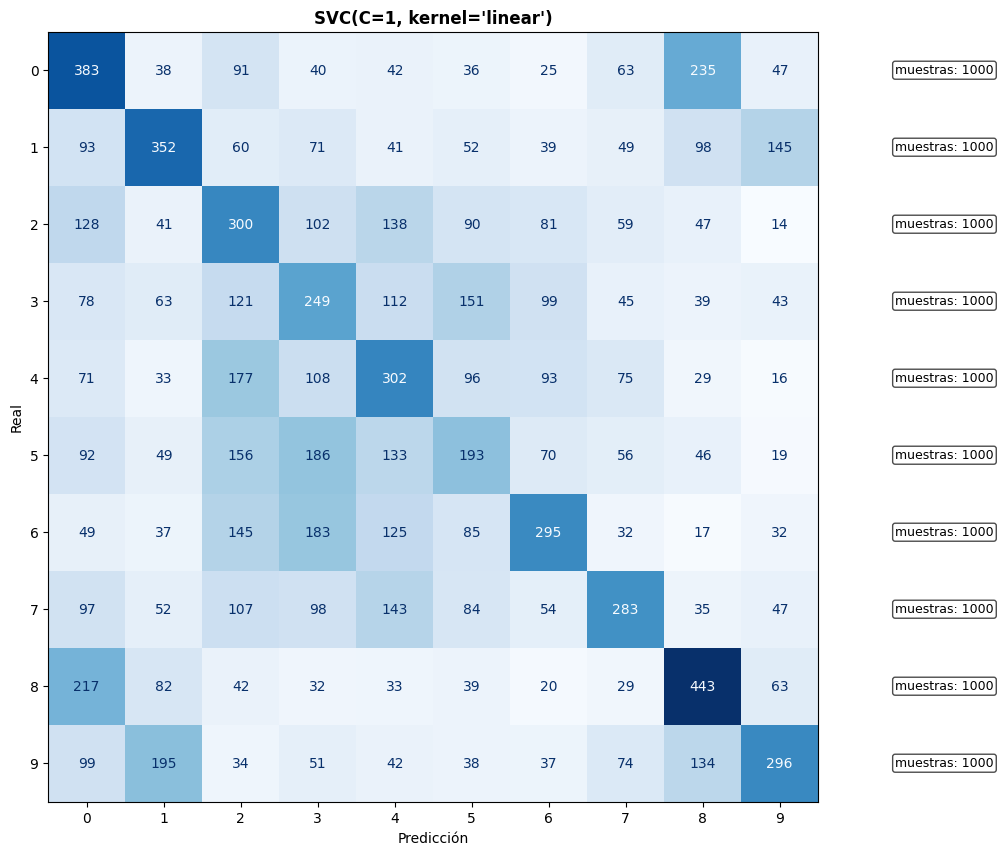

In [22]:
mc_modelo_KL=confusion_matrix(y_test, predicciones_KL)
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=mc_modelo_KL, display_labels=np.arange(10))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title(modelo_1, fontweight='bold')  # Añade el nombre del modelo
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Añadir anotación con total de muestras a la derecha de cada fila
samples_per_class1 = mc_modelo_KL.sum(axis=1)
for i in range(10):
        ax.text(10.5, i, f"muestras: {samples_per_class1[i]}",
                ha='left', va='center', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

### Kernel Gausiano

  - Búsqueda óptima de C

In [23]:
par_KG_CIF = {'C': [1, 10, 100]}

timeIni2 = time()
grid2 = GridSearchCV(SVC(kernel='rbf'), par_KG_CIF)
grid2.fit(x_train_uni[:1000],y_train[:1000])
timeEnd2 = time()
timeDiff2 = datetime.datetime.fromtimestamp(timeEnd2-timeIni2).strftime("%M:%S:%f")

print("La mejor parametrización para la SVM (en el conjunto de training) es: ", grid2.best_params_)
print("Tiempo necesario para su cómputo: ", timeDiff2)

La mejor parametrización para la SVM (en el conjunto de training) es:  {'C': 1}
Tiempo necesario para su cómputo:  00:47:289464


Dado el que el tiempo de busqueda de los parámetros resultó excesivo con 20,000 y 5,000 imágenes, reduje hasta 1,000. Como se observa, el C óptimo del kernel gausiano es de C=1.

#### Entrenar modelo

In [24]:
timeIni22 = time()
modelo_2 = SVC(kernel = "rbf", C=1).fit(x_train_uni[:5000],y_train[:5000])
print(modelo_2)
timeEnd22 = time()
timeDiff22 = datetime.datetime.fromtimestamp(timeEnd22-timeIni22).strftime("%M:%S:%f")

Acc2 = modelo_2.score(x_test_uni, y_test)
print("Precisión (accuracy): ", Acc2)
print("Tiempo entrenamiento: ", timeDiff22)

SVC(C=1)
Precisión (accuracy):  0.4435
Tiempo entrenamiento:  00:52:924169


#### Testear modelo

In [25]:
predicciones_KG = modelo_2.predict(x_test_uni)

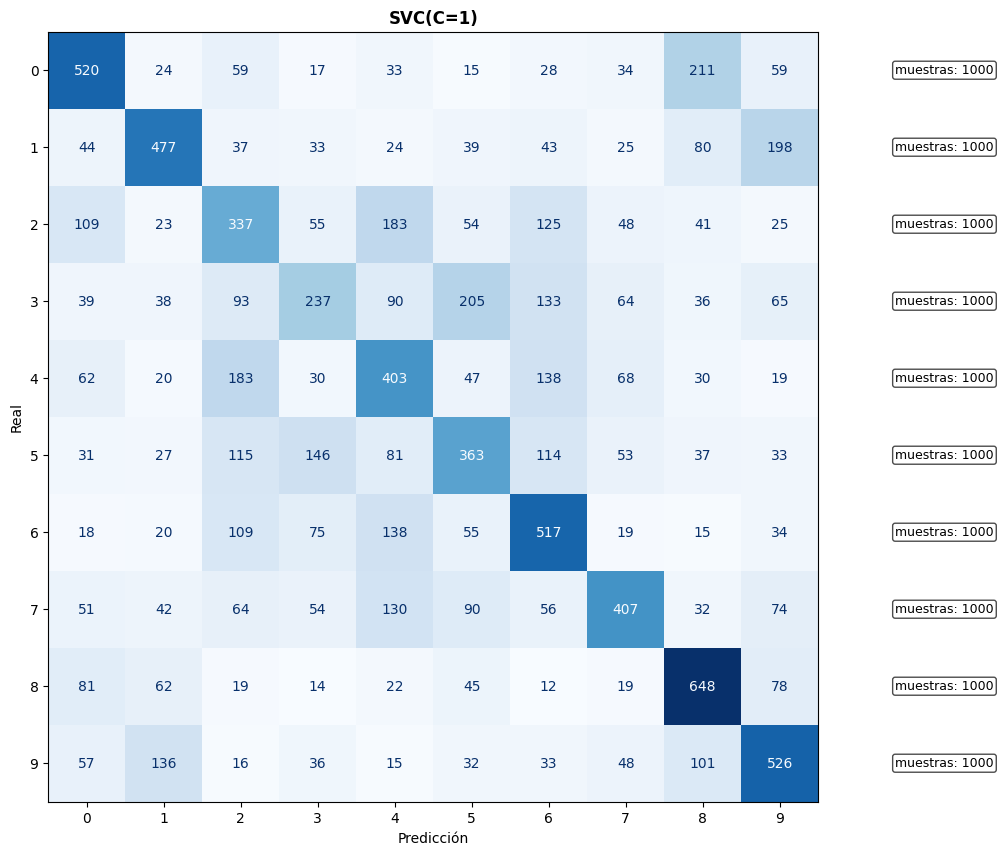

In [26]:
mc_modelo_KG=confusion_matrix(y_test, predicciones_KG)
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=mc_modelo_KG, display_labels=np.arange(10))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title(modelo_2, fontweight='bold')  # Añade el nombre del modelo
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Añadir anotación con total de muestras a la derecha de cada fila
samples_per_class2 = mc_modelo_KL.sum(axis=1)
for i in range(10):
        ax.text(10.5, i, f"muestras: {samples_per_class2[i]}",
                ha='left', va='center', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

## EUROSAT RGB

### Kernel lineal

  - Búsqueda de C

In [27]:
par_KL_EURO={'C': [1, 10, 100]}

y_train_EURO= y_train_EURO.ravel()
timeIni3=time()
grid3=GridSearchCV(SVC(kernel='linear'),par_KL_EURO)
grid3.fit(X_train_EURO[:1000],y_train_EURO[:1000])
timeFin3=time()
timeDiff3=datetime.datetime.fromtimestamp(timeFin3-timeIni3).strftime('%M:%S:%f')

print("Mejor valor de C: ",grid3.best_params_)
print("Tiempo de ejecución: ",timeDiff3)

Mejor valor de C:  {'C': 1}
Tiempo de ejecución:  02:10:268340


Como puede observarse, el C óptimo es igual a 1.

#### Entrenar modelo

In [28]:
timeIni33 = time()
modelo_3 = SVC(kernel = "linear", C=1).fit(X_train_EURO[:5000],y_train_EURO[:5000])
print(modelo_3)
timeEnd33 = time()
timeDiff33 = datetime.datetime.fromtimestamp(timeEnd33-timeIni33).strftime("%M:%S:%f")

Acc3 = modelo_3.score(X_test_EURO, y_test_EURO)
print("Precisión (accuracy): ", Acc3)
print("Tiempo entrenamiento: ", timeDiff33)

SVC(C=1, kernel='linear')
Precisión (accuracy):  0.38203703703703706
Tiempo entrenamiento:  05:41:565321


#### Testear el modelo

In [29]:
predicciones_KL_EURO = modelo_3.predict(X_test_EURO)

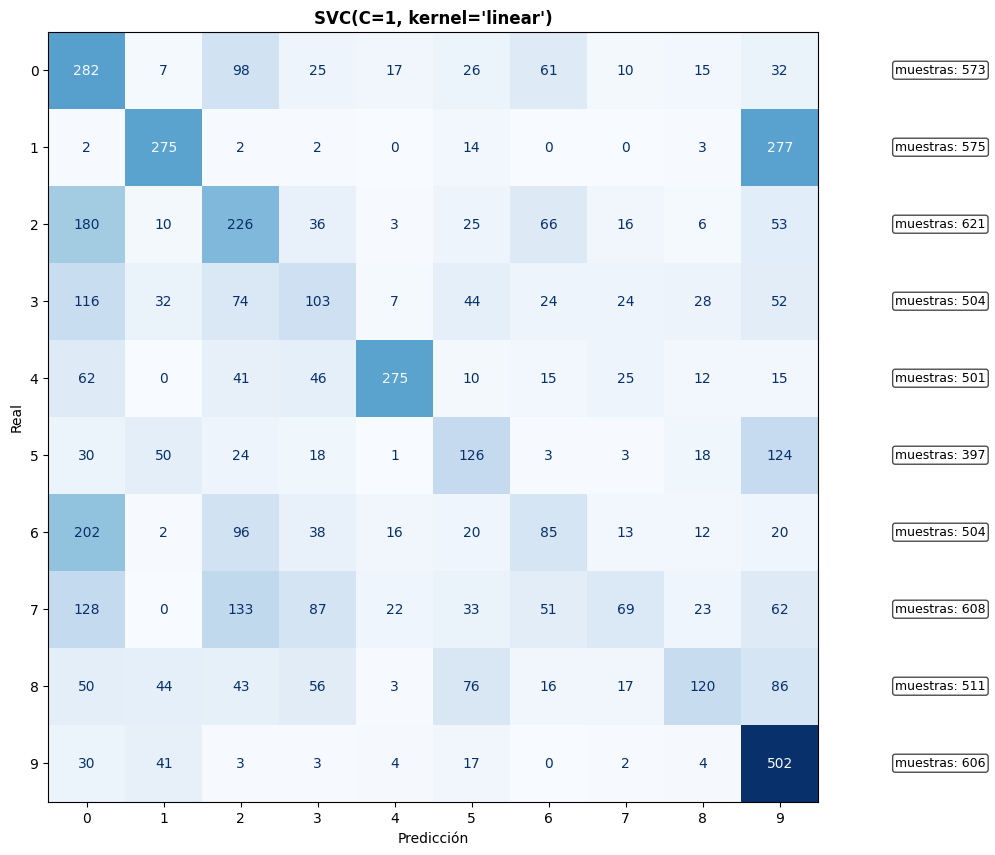

In [30]:
mc_modelo_KL_EURO=confusion_matrix(y_test_EURO, predicciones_KL_EURO)
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=mc_modelo_KL_EURO, display_labels=np.arange(10))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title(modelo_3, fontweight='bold')  # Añade el nombre del modelo
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Añadir anotación con total de muestras a la derecha de cada fila
samples_per_class3 = mc_modelo_KL_EURO.sum(axis=1)
for i in range(10):
        ax.text(10.5, i, f"muestras: {samples_per_class3[i]}",
                ha='left', va='center', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

### Kernel Gausiano

  - Búsqueda óptima de C

In [31]:
par_KG_EURO = {'C': [1, 10, 100]}

timeIni4 = time()
grid4 = GridSearchCV(SVC(kernel='rbf'), par_KG_EURO)
grid4.fit(X_train_EURO[:1000],y_train_EURO[:1000])
timeEnd4 = time()
timeDiff4 = datetime.datetime.fromtimestamp(timeEnd4-timeIni4).strftime("%M:%S:%f")

print("La mejor parametrización para la SVM (en el conjunto de training) es: ", grid4.best_params_)
print("Tiempo necesario para su cómputo: ", timeDiff4)

La mejor parametrización para la SVM (en el conjunto de training) es:  {'C': 10}
Tiempo necesario para su cómputo:  02:24:953826


#### Entrenar el modelo

In [32]:
timeIni44 = time()
modelo_4 = SVC(kernel = "rbf", C=1).fit(X_train_EURO[:5000],y_train_EURO[:5000])
print(modelo_4)
timeEnd44 = time()
timeDiff44 = datetime.datetime.fromtimestamp(timeEnd44-timeIni44).strftime("%M:%S:%f")

Acc4 = modelo_4.score(X_test_EURO, y_test_EURO)
print("Precisión (accuracy): ", Acc4)
print("Tiempo entrenamiento: ", timeDiff44)

SVC(C=1)
Precisión (accuracy):  0.6275925925925926
Tiempo entrenamiento:  04:00:501880


#### Testear el modelo



In [33]:
predicciones_KG_EURO = modelo_4.predict(X_test_EURO)

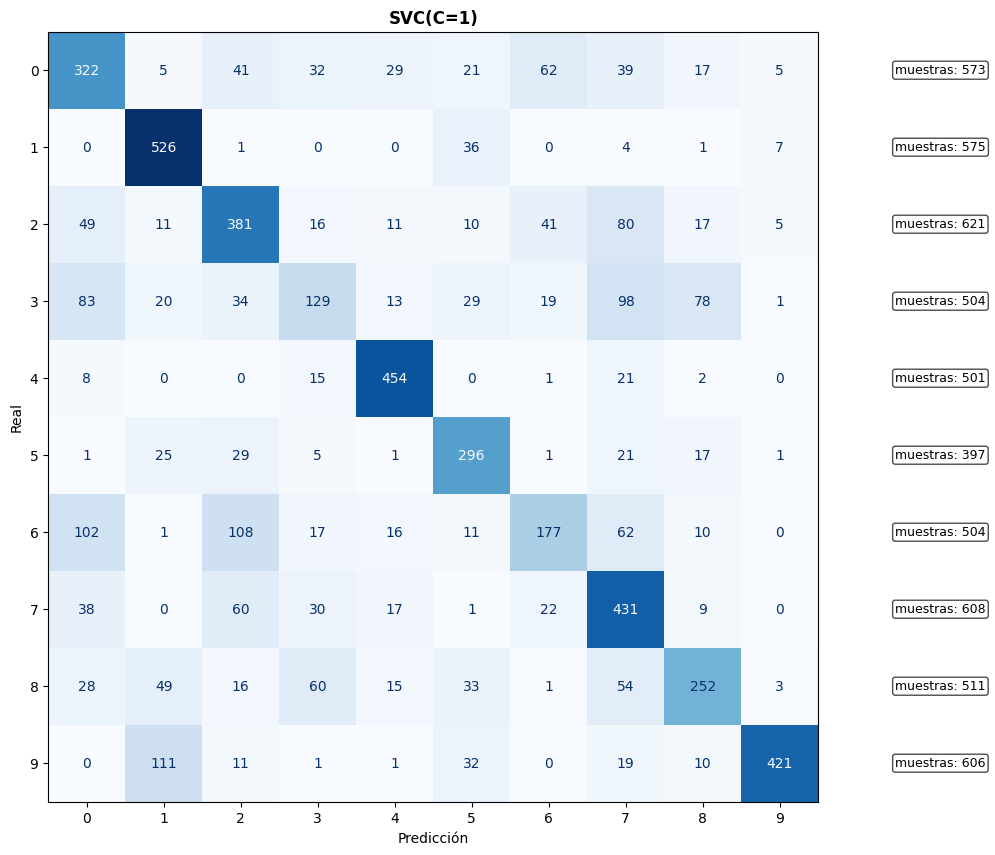

In [34]:
mc_modelo_KG_EURO=confusion_matrix(y_test_EURO, predicciones_KG_EURO)
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=mc_modelo_KG_EURO, display_labels=np.arange(10))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title(modelo_4, fontweight='bold')  # Añade el nombre del modelo
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")

# Añadir anotación con total de muestras a la derecha de cada fila
samples_per_class4 = mc_modelo_KG_EURO.sum(axis=1)
for i in range(10):
        ax.text(10.5, i, f"muestras: {samples_per_class4[i]}",
                ha='left', va='center', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

##Resultados

Comparativo de matrices de confusion

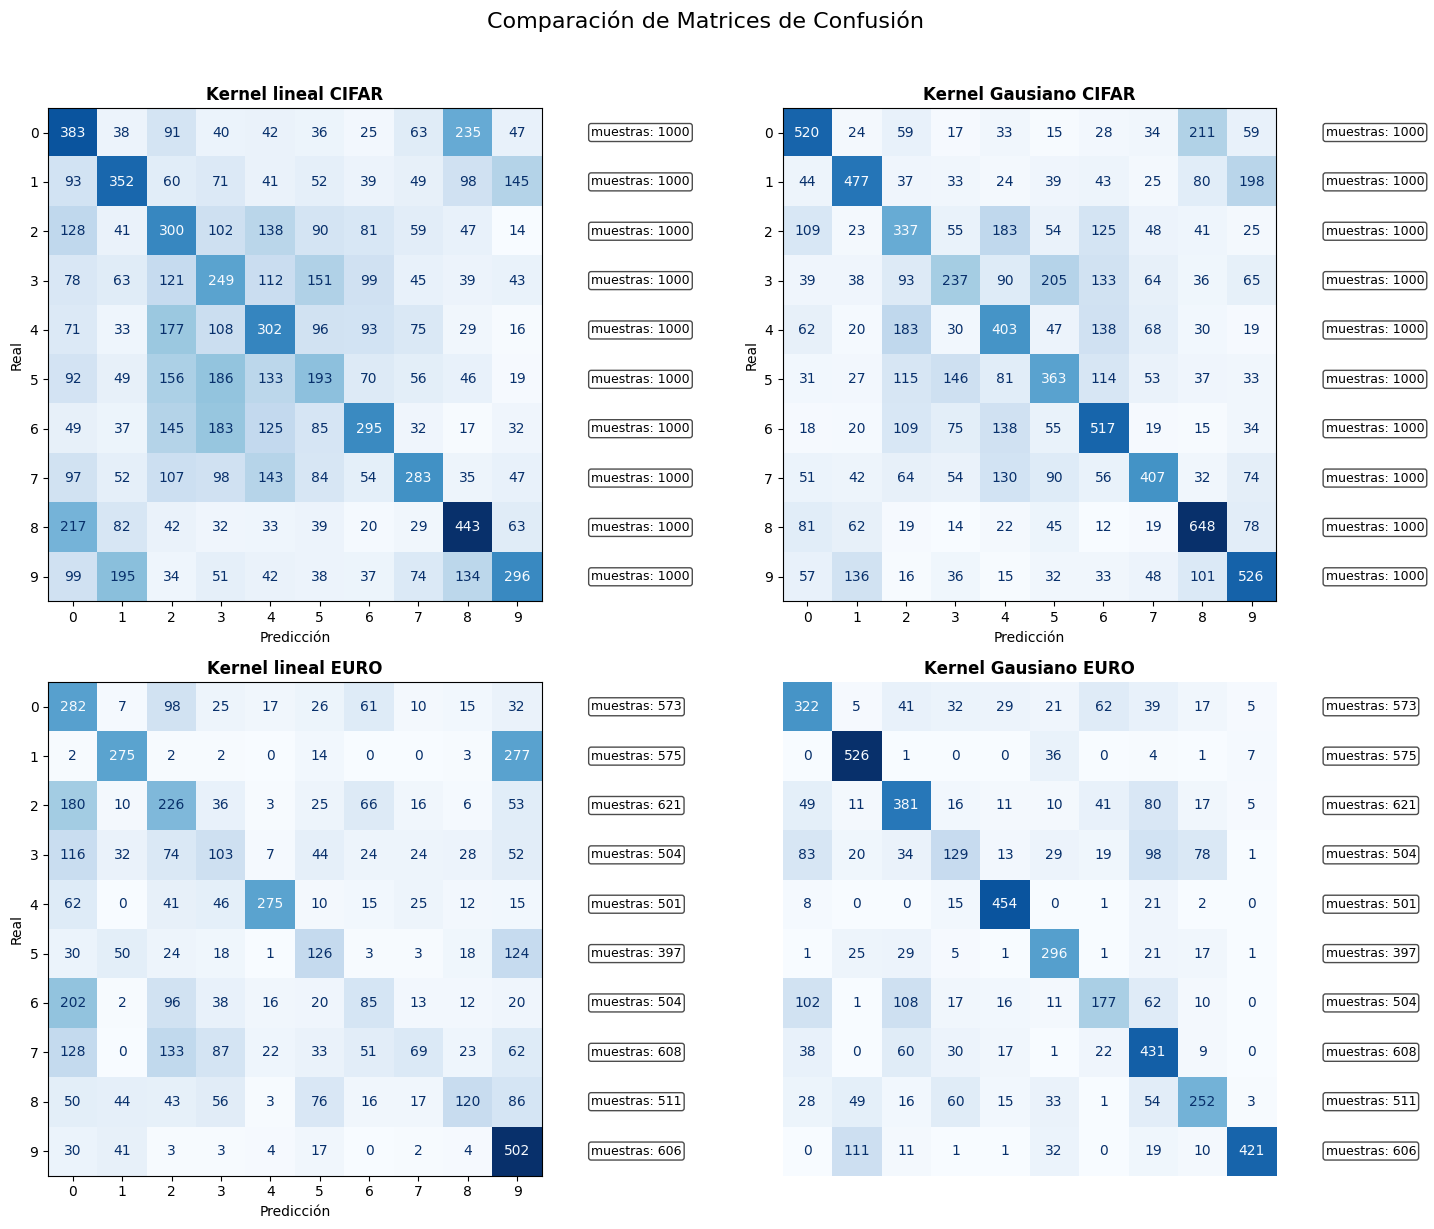

In [35]:
# Configuración del gráfico (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Comparación de Matrices de Confusión", fontsize=16, y=1.02)

# Lista de modelos y sus matrices (en el mismo orden)
models = {
    "Kernel lineal CIFAR": mc_modelo_KL,
    "Kernel Gausiano CIFAR": mc_modelo_KG,
    "Kernel lineal EURO": mc_modelo_KL_EURO,
    "Kernel Gausiano EURO": mc_modelo_KG_EURO
    }

# Generar cada subgráfico
for ax, (model_name, cm) in zip(axes.flatten(), models.items()):
    samples_per_class = cm.sum(axis=1)   # Calcular total de muestras por clase (suma por fila)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(model_name, fontweight='bold')  # Añade el nombre del modelo
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

    # Añadir anotación con total de muestras a la derecha de cada fila
    for i in range(10):
        ax.text(10.5, i, f"muestras: {samples_per_class[i]}",
                ha='left', va='center', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Ajustar espacios y mostrar
if len(models) < 6:
    axes[-1, -1].axis('off') #ocultar espacio no utilizado

plt.tight_layout()
plt.show()

Comparativo de Accuracy

In [45]:
#Comparación de los modelos de clasificacion
display(HTML("Comparación de Modelos"))
#Género
Metricas_Gen = pd.DataFrame({
    'Métrica': ['Accuracy', 'Time'],
    'Kernel L (CIFAR)': [
        f"{Acc1:.3f}",
        f"{timeDiff11}"
    ],
    'Kernel G (CIFAR)': [
        f"{Acc2:.3f}",
        f"{timeDiff22}"
    ],
    'Kernel L (EURO)': [
        f"{Acc3:.3f}",
        f"{timeDiff33}"
    ],
    'Kernel G (EURO)': [
        f"{Acc4:.3f}",
        f"{timeDiff44}"
    ]
})
# Tabla comparativa
Metricas_Gen = Metricas_Gen.set_index('Métrica')
print(Metricas_Gen)


         Kernel L (CIFAR) Kernel G (CIFAR) Kernel L (EURO) Kernel G (EURO)
Métrica                                                                   
Accuracy            0.310            0.444           0.382           0.628
Time         01:11:023725     00:52:924169    05:41:565321    04:00:501880


Conclusiones

Como puede observarse, en términos de Accuracy el mejor modelo es con el Kernel Gausiano para ambos conjuntos de datos. En el conjunto de datos EUROSAT RGB, la precisión del modelo mejoró considerablemente con el kernel gausiano, al pasar de 0,382 hasta 0,628. En el caso del dataset CIFAR, tambien el kernel se incrementó de 0,310 hasta 0,444. Se puede concluir que el kernel gausiano, aun sin optimizar los parámetros gamma y probability, es mejor que el kernel lineal.

En términos de tiempo de entrenamiento, el kernel gausiano se desempeño mejor en ambos datasets, aunque si fue elevado con respecto a otros modelos de clasificación como random forest y knn.
Si se observa la matriz de confusión, observamos que la imagen que mejor predicen ambos modelos es la etiqueta 8 (ship) en CIFAR (lineal 44,3% y gausiano 64,8%). En el caso de EUROSAT, el kernel lineal predice mejor la etiqueta 9 (SeaLake-82,8%) mientras que el kernel gausiano la etiqueta 2 (HerbaceousVegetation-91,4%).

Sin embargo, en todos los casos el parámetro de tuning (C) fue de 1. Esto fue muy cercano a ejecutar el modelo de Margen Máximo, ya que no se permitió una tolerancia de errores para entrenar los modelos. En todos los caso intenté una estrategia de reducir la dimensionalidad mediante PCA pero el proceso resultó igual de lento. Por ello, decidí utilizar solo 1000 imágenes para encontrar el C óptimo, 5,000 imágenes para entrenar el modelo y el set completo de prueba para realizar las predicciones. Esto afectó considerablemente la capacidad predictiva de los modelos en todos los casos.